# Section 1: Clinical Data Pipeline & Analysis

## Setup

In [1]:
# !python3.10 -m pip install boto3 psycopg2-binary matplotlib pandas dotenv
# aws configure
# aws dynamodb describe-table --table-name clinical_notes
# aws dynamodb scan --table-name clinical_notes

In [2]:
# Read DynamoDB
import boto3, pandas as pd
from decimal import Decimal
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

def get_dynamo_connection():
    """
    Create DynamoDB connection using environment variables
    Returns DynamoDB table resource
    """
    return boto3.resource(
        "dynamodb",
        region_name=os.getenv("AWS_REGION", "us-west-2"),
        aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
        aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY")
    ).Table(os.getenv("DYNAMODB_TABLE", "clinical_notes"))

def conv(x):
    """Convert DynamoDB types to Python native types"""
    if isinstance(x, list):  return [conv(v) for v in x]
    if isinstance(x, dict):  return {k: conv(v) for k,v in x.items()}
    if isinstance(x, Decimal): return int(x) if x % 1 == 0 else float(x)
    return x

def read_dynamo_data(batch_size=10000):
    """
    Read data from DynamoDB in batches
    Returns pandas DataFrame
    """
    tbl = get_dynamo_connection()
    
    start_key = None
    batch = []
    all_batches = []
    
    while True:
        scan_kwargs = {}
        if start_key:
            scan_kwargs["ExclusiveStartKey"] = start_key
            
        resp = tbl.scan(**scan_kwargs)
        for item in resp.get("Items", []):
            batch.append(conv(item))
            if len(batch) >= batch_size:
                all_batches.append(pd.json_normalize(batch))
                batch.clear()
                
        start_key = resp.get("LastEvaluatedKey")
        if not start_key:
            break

    if batch:
        all_batches.append(pd.json_normalize(batch))
        
    return pd.concat(all_batches, ignore_index=True) if all_batches else pd.DataFrame()

# Read data from DynamoDB
dynamo_df = read_dynamo_data()
# dynamo_df


In [3]:
# Read Postgresql
import psycopg2, psycopg2.extras as extras

# PostgreSQL connection parameters from environment variables
conn = psycopg2.connect(
    dbname=os.getenv("POSTGRES_DB", "postgres"),
    user=os.getenv("POSTGRES_USER", "postgres"), 
    password=os.getenv("POSTGRES_PASSWORD"),
    host=os.getenv("POSTGRES_HOST"),
    port=os.getenv("POSTGRES_PORT", 5432),
)
conn.set_session(readonly=True, autocommit=False)

BATCH = int(os.getenv("POSTGRES_BATCH_SIZE", 10000))

frames = []
with conn:
    with conn.cursor() as ctl:
        ctl.execute("SET statement_timeout = 600000")

    with conn.cursor(name="stream_notes", cursor_factory=extras.RealDictCursor) as cur:
        cur.itersize = BATCH
        cur.execute('SELECT * FROM public.clinical_notes')

        while True:
            rows = cur.fetchmany(BATCH)
            if not rows:
                break
            frames.append(pd.DataFrame(rows))

postgre_df = pd.concat(frames, ignore_index=True)

In [4]:
for df in (dynamo_df, postgre_df):
    df["patient_id"] = df["patient_id"].astype(str)


dyn_cols_map = {
    "patient_id": "patient_id",
    "history_of_present_illness": "hpi",
    "original_transcript": "transcript",
    "reviewed_note": "note_reviewed",
    "soap_note": "note_ai",
    "audio_upload_date": "appt_date",
    "job_start_time": "job_start_time",
    "job_end_time": "job_end_time",
    "Doctor": "doctor_name",
    "reviewer_id": "reviewer_id",
    "icd10_codes.icd10_codes_res": "icd10_plain_codes",
    "icd10_codes.icd10_res": "icd10_named_codes",
    "icd10_codes_v2" : "icd10_codes_v2",
    "faithfulness_score" : "faithfulness_outof_1",
    "point_coverage_score" : "coverage_outof_1",
    "structured_score" : "structured_outof_1"
}
dyn_keep = [c for c in dyn_cols_map if c in dynamo_df.columns]
dyn_sel = dynamo_df[dyn_keep].rename(columns={k:v for k,v in dyn_cols_map.items() if k in dyn_keep}).copy()



pg_cols_map = {
    "patient_id": "patient_id",
    "hpi": "hpi",
    "description": "patient_name",
    "diarized_transcript": "transcript",
    "note": "note_ground_truth",
    "date_of_appt": "appt_date",
    "created_at": "created_at",
    "time_spent": "time_spent",
    "user_id": "user_id",
    "icd_10_codes":"icd10_codes",
    "icd10_codes_v2": "icd10_codes_v2"
}
pg_keep = [c for c in pg_cols_map if c in postgre_df.columns]
pg_sel = postgre_df[pg_keep].rename(columns={k:v for k,v in pg_cols_map.items() if k in pg_keep}).copy()


df = pd.merge(dyn_sel, pg_sel, on="patient_id", how="inner", suffixes=("_dyn", "_pg"))

# list(merged.columns)

## Analytics

## Scores Distribution

In [5]:
def print_score_summary(df, score_type, score_col):
    """Print summary statistics for a given score column."""
    if score_col in df.columns:
        # Convert to numeric and drop NaN values
        scores = pd.to_numeric(df[score_col], errors='coerce').dropna()
        if len(scores) > 0:
            stats = scores.describe()
            print(f"\n{score_type}:")
            print(f"- Mean: {stats['mean']:.3f}")
            print(f"- Median: {stats['50%']:.3f}") 
            print(f"- Standard Deviation: {stats['std']:.3f}")
            print(f"- Range: {stats['min']:.3f} to {stats['max']:.3f}")
            print(f"- Number of valid scores: {len(scores)}")
        else:
            print(f"\n{score_type}: No valid numeric scores found")
    else:
        print(f"\n{score_type}: Column '{score_col}' not found in dataframe")

def generate_score_summary(df):
    """Generate summary statistics for all score columns."""
    print("Score Distribution Summary:")
    
    # Define expected score columns
    scores = {
        'Faithfulness Score': 'faithfulness_outof_1',
        'Coverage Score': 'coverage_outof_1', 
        'Structured Score': 'structured_outof_1'
    }
    
    # Verify columns exist in dataframe
    missing_cols = [col for col in scores.values() if col not in df.columns]
    if missing_cols:
        print(f"\nWarning: The following score columns are missing: {missing_cols}")
        # Remove missing columns from scores dict
        scores = {k:v for k,v in scores.items() if v not in missing_cols}
    
    # Check if dataframe is empty
    if df.empty:
        print("\nDataframe is empty - no scores to analyze")
        return
        
    for score_type, col in scores.items():
        print_score_summary(df, score_type, col)

# Generate the summary
generate_score_summary(df)


Score Distribution Summary:

Faithfulness Score:
- Mean: 0.827
- Median: 0.850
- Standard Deviation: 0.117
- Range: 0.700 to 0.950
- Number of valid scores: 11

Coverage Score:
- Mean: 0.827
- Median: 0.818
- Standard Deviation: 0.120
- Range: 0.607 to 1.000
- Number of valid scores: 11

Structured Score:
- Mean: 1.000
- Median: 1.000
- Standard Deviation: 0.000
- Range: 1.000 to 1.000
- Number of valid scores: 11


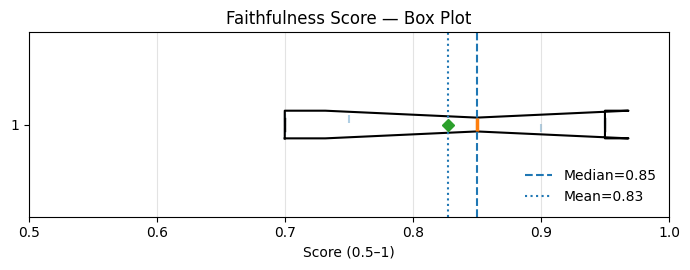

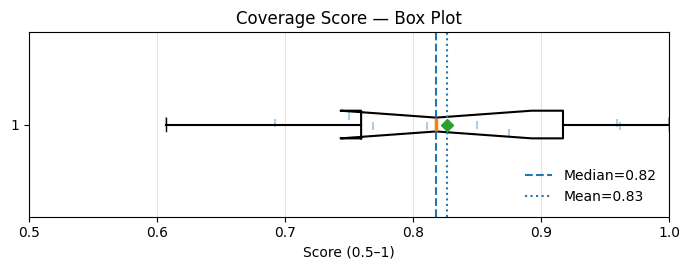

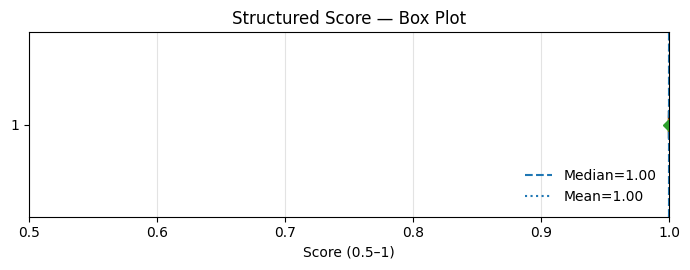

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

candidate_cols = {
    'faithfulness_outof_1': 'Faithfulness Score',
    'coverage_outof_1': 'Coverage Score',
    'structured_outof_1': 'Structured Score'
}
existing = {c: n for c, n in candidate_cols.items() if c in df.columns}

def plot_box(s, title):
    s = pd.to_numeric(s, errors='coerce').dropna().astype(float)
    if s.empty:
        return

    q1, q2, q3 = s.quantile([0.25, 0.5, 0.75])   # quartiles 四分位
    mean = s.mean()

    fig, ax = plt.subplots(figsize=(7, 2.8))
    ax.boxplot(
        s, vert=False, showmeans=True, notch=True,
        medianprops=dict(linewidth=2.5),                 # median
        meanprops=dict(marker='D', markersize=6),        # mean
        whiskerprops=dict(linewidth=1.5),                # whisker
        boxprops=dict(linewidth=1.5),
        flierprops=dict(markersize=4, alpha=0.5)         # outliers
    )

    y = 1 + (np.random.rand(len(s)) - 0.5) * 0.10
    ax.scatter(s, y, marker='|', s=30, alpha=0.35)

    mline = ax.axvline(mean, linestyle=':', linewidth=1.5)
    medline = ax.axvline(q2, linestyle='--', linewidth=1.5)
    ax.legend([medline, mline],
              [f"Median={q2:.2f}", f"Mean={mean:.2f}"],
              loc='lower right', frameon=False)

    bounded = s.min() >= 0 and s.max() <= 1.0
    if bounded:
        ax.set_xlim(0.5, 1)
        ax.set_xlabel('Score (0.5–1)')
    else:
        ax.set_xlabel('Value')

    ax.set_title(f'{title} — Box Plot')
    ax.grid(True, axis='x', alpha=0.35)
    fig.tight_layout()
    plt.show()

for col, name in existing.items():
    plot_box(df[col], name)


## Processing Time

In [7]:
class TimeAnalyzer:
    def __init__(self, df):
        self.df = df
        self.t_col = "time_spent_min" if "time_spent_min" in df.columns else "time_spent"
        self.p_col = "processing_time_min" if "processing_time_min" in df.columns else "processing_time"
        
    def process_time_columns(self, strict: bool = False, create_missing: bool = True):
        def to_dt(s):
            return pd.to_datetime(s, errors="coerce", utc=True)

        df = self.df.copy()

        have_start = "job_start_time" in df.columns
        have_end = "job_end_time" in df.columns
        if strict and not (have_start and have_end):
            missing = [c for c in ("job_start_time", "job_end_time") if c not in df.columns]
            raise KeyError(f"Missing required time columns: {missing}")

        if create_missing and "processing_time_min" not in df.columns:
            try:
                df["processing_time_min"] = pd.Series([pd.NA] * len(df), dtype="Float64")
            except Exception:
                df["processing_time_min"] = None

        if have_start and have_end:
            start_dt = to_dt(df["job_start_time"])
            end_dt = to_dt(df["job_end_time"])
            proc_secs = (end_dt - start_dt).dt.total_seconds()
            proc_secs = proc_secs.where((proc_secs >= 0) & (proc_secs <= 7 * 24 * 3600))
            df["processing_time_min"] = (proc_secs / 60).round(2)

        if "time_spent" in df.columns:
            df["time_spent"] = pd.to_numeric(df["time_spent"], errors="coerce").astype("float64")
        elif create_missing:
            try:
                df["time_spent"] = pd.Series([pd.NA] * len(df), dtype="Float64")
            except Exception:
                df["time_spent"] = None

        self.df = df
        # Recompute column choices AFTER processing
        self.t_col = "time_spent_min" if "time_spent_min" in df.columns else "time_spent"
        self.p_col = "processing_time_min" if "processing_time_min" in df.columns else "processing_time"
        return df

    def get_doctor_stats(self):
        """Calculate and return doctor statistics"""
        # Check if columns exist before grouping
        cols = ["doctor_name"]
        if self.t_col in self.df.columns:
            cols.append(self.t_col)
        if self.p_col in self.df.columns:
            cols.append(self.p_col)
            
        g = (
            self.df[cols]
            .replace([np.inf, -np.inf], np.nan)
            .dropna(subset=[col for col in cols if col != "doctor_name"])
            .groupby("doctor_name", as_index=False)
            .mean()
        )
        return g

    def get_longest_processing_doctor(self):
        """Find doctor with longest app usage time"""
        g = self.get_doctor_stats()
        if self.p_col not in g.columns:
            return {
                'name': None,
                'time': None
            }
        longest_proc_doc = g.nlargest(1, self.p_col)
        return {
            'name': longest_proc_doc['doctor_name'].values[0],
            'time': longest_proc_doc[self.p_col].values[0]
        }

    def get_longest_review_doctor(self):
        """Find doctor who spent longest time reviewing notes"""
        g = self.get_doctor_stats()
        if self.t_col not in g.columns:
            return {
                'name': None,
                'time': None
            }
        longest_time_doc = g.nlargest(1, self.t_col)
        return {
            'name': longest_time_doc['doctor_name'].values[0],
            'time': longest_time_doc[self.t_col].values[0]
        }

    def get_top_review_doctors(self, n=3):
        """Get top N doctors by average review time"""
        g = self.get_doctor_stats()
        if self.t_col not in g.columns:
            return []
        top_n_docs = g.nlargest(n, self.t_col)[['doctor_name', self.t_col]]
        return [(row['doctor_name'], row[self.t_col]) for _, row in top_n_docs.iterrows()]

# Example usage:
analyzer = TimeAnalyzer(df)
analyzer.process_time_columns()

# Get longest processing time doctor
longest_proc = analyzer.get_longest_processing_doctor()
if longest_proc['name'] is not None:
    print(f"\nDoctor {longest_proc['name']} has the longest average processing time on app: {longest_proc['time']:.2f} minutes")
else:
    print("\nNo processing time data available")

# Get longest review time doctor
longest_review = analyzer.get_longest_review_doctor()
if longest_review['name'] is not None:
    print(f"\nDoctor who spent the longest average time reviewing notes (both in-app and by-themselves): {longest_review['name']}")
    print(f"The average review time: {longest_review['time']:.2f} minutes")
else:
    print("\nNo review time data available")

# Get top 3 doctors
print("\nTop 3 doctors by average note review time (both in-app and by-themselves):")
top_doctors = analyzer.get_top_review_doctors(3)
if top_doctors:
    for name, time in top_doctors:
        print(f"Dr. {name}: {time:.2f} minutes per note")
else:
    print("No review time data available")


Doctor Dr.Moazami has the longest average processing time on app: 1.67 minutes

Doctor who spent the longest average time reviewing notes (both in-app and by-themselves): Dr.Bhatt
The average review time: 41.88 minutes

Top 3 doctors by average note review time (both in-app and by-themselves):
Dr. Dr.Bhatt: 41.88 minutes per note
Dr. Dr.Adenwalla: 36.42 minutes per note
Dr. Dr.Caracitas: 31.56 minutes per note


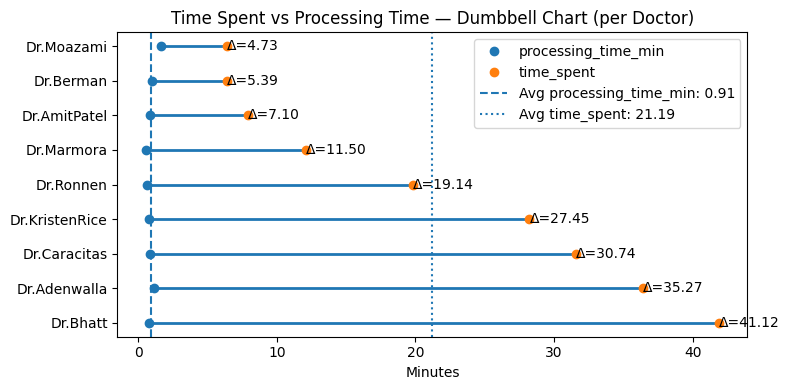

In [8]:
df = analyzer.process_time_columns()
t_col = "time_spent_min" if "time_spent_min" in df.columns else "time_spent"
p_col = "processing_time_min" if "processing_time_min" in df.columns else "processing_time"

g = (
    df[["doctor_name", t_col, p_col]]
    .replace([np.inf, -np.inf], np.nan)
    .dropna(subset=[t_col, p_col])
    .groupby("doctor_name", as_index=False)
    .mean()
)

g["abs_diff"] = (g[t_col] - g[p_col]).abs()
avg_proc  = g[p_col].mean()    # 平均 processing time
avg_spent = g[t_col].mean()    # 平均 time spent


top_n = 25
pairs = g.nlargest(top_n, "abs_diff").sort_values("abs_diff")

fig, ax = plt.subplots(figsize=(8, max(4, 0.35*len(pairs))))
y = np.arange(len(pairs))
x_proc  = pairs[p_col].to_numpy()
x_spent = pairs[t_col].to_numpy()
labels  = pairs["doctor_name"].to_numpy()

ax.hlines(y, x_proc, x_spent, linewidth=2)
ax.plot(x_proc,  y, "o", label=p_col)
ax.plot(x_spent, y, "o", label=t_col)

for i, d in enumerate(pairs["abs_diff"].to_numpy()):
    ax.text(max(x_proc[i], x_spent[i]), y[i], f"Δ={d:.2f}", va="center", ha="left")

ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.invert_yaxis()
ax.set_xlabel("Minutes")
ax.set_title("Time Spent vs Processing Time — Dumbbell Chart (per Doctor)")
ax.axvline(avg_proc,  linestyle="--", linewidth=1.5, label=f"Avg {p_col}: {avg_proc:.2f}")
ax.axvline(avg_spent, linestyle=":",  linewidth=1.5, label=f"Avg {t_col}: {avg_spent:.2f}")
ax.legend()
plt.tight_layout()
plt.show()


## Transcript Length

In [9]:
class TranscriptAnalyzer:
    def __init__(self, df, transcript_col="transcript_dyn", doctor_col="doctor_name"):
        """
        Initialize transcript analyzer
        
        Args:
            df: pandas DataFrame containing transcript data
            transcript_col: column name containing transcript text
            doctor_col: column name containing doctor identifiers
        """
        self.df = df
        self.transcript_col = transcript_col
        self.doctor_col = doctor_col
        
    def compute_transcript_lengths(self):
        """Calculate transcript lengths and add as new column"""
        # Get basic stats
        length_stats = self.df[self.transcript_col].apply(len).describe()
        print(length_stats)
        
        # Add length column
        self.df["transcript_len"] = (self.df[self.transcript_col]
                                   .fillna("")
                                   .astype(str)
                                   .str.len())
        
    def get_doctor_stats(self):
        """Get transcript length statistics grouped by doctor"""
        stats_by_doc = (
            self.df.groupby(self.doctor_col, dropna=False)["transcript_len"]
            .agg(n="count", 
                 mean="mean",
                 median="median", 
                 min="min",
                 p25=lambda s: s.quantile(0.25),
                 p75=lambda s: s.quantile(0.75),
                 max="max")
            .sort_values("mean", ascending=False)
        )
        return stats_by_doc
        
    def analyze_transcript_stats(self, stats_by_group):
        """Analyze transcript length statistics and return formatted results"""
        # Calculate ranges
        stats_by_group = stats_by_group.copy()
        stats_by_group['range'] = stats_by_group['max'] - stats_by_group['min'] 
        stats_by_group['iqr'] = stats_by_group['p75'] - stats_by_group['p25']
        
        # Get key statistics
        highest_mean = stats_by_group.sort_values("mean", ascending=False).head(1)
        widest_range = stats_by_group.sort_values("range", ascending=False).head(1)
        largest_iqr = stats_by_group.sort_values("iqr", ascending=False).head(1)
        
        # Format results as dictionary
        analysis_results = {
            'summary': f"The doctor with the highest mean transcript length is {highest_mean.index[0]}, suggesting they tend to have longer visits.",
            'highest_mean_doctor': highest_mean,
            'widest_range_doctor': widest_range,
            'largest_iqr_doctor': largest_iqr
        }
        
        return analysis_results

# Usage example:
analyzer = TranscriptAnalyzer(df)
analyzer.compute_transcript_lengths()
stats_by_doc = analyzer.get_doctor_stats()
analyzer.analyze_transcript_stats(stats_by_doc)

count       14.000000
mean     14767.071429
std      11146.101950
min       2823.000000
25%       5974.500000
50%      11688.500000
75%      22941.750000
max      41497.000000
Name: transcript_dyn, dtype: float64


{'summary': 'The doctor with the highest mean transcript length is Dr.Bhatt, suggesting they tend to have longer visits.',
 'highest_mean_doctor':              n     mean   median    min       p25       p75    max  range  \
 doctor_name                                                                 
 Dr.Bhatt     2  27989.5  27989.5  14482  21235.75  34743.25  41497  27015   
 
                  iqr  
 doctor_name           
 Dr.Bhatt     13507.5  ,
 'widest_range_doctor':              n     mean   median    min       p25       p75    max  range  \
 doctor_name                                                                 
 Dr.Bhatt     2  27989.5  27989.5  14482  21235.75  34743.25  41497  27015   
 
                  iqr  
 doctor_name           
 Dr.Bhatt     13507.5  ,
 'largest_iqr_doctor':              n     mean   median    min       p25       p75    max  range  \
 doctor_name                                                                 
 Dr.Bhatt     2  27989.5  27989.5  

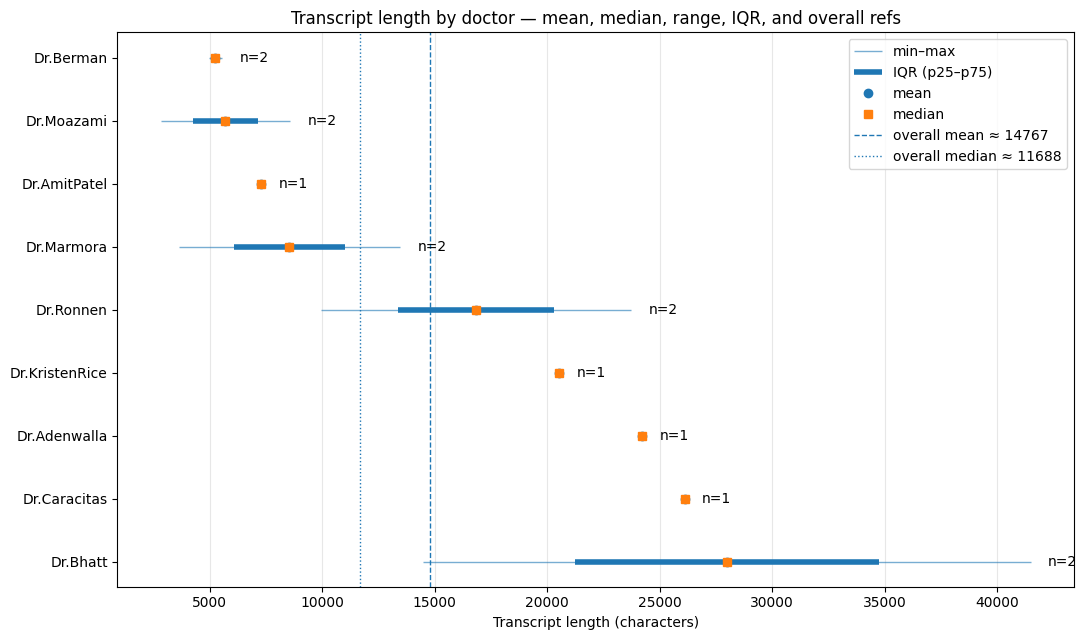

In [10]:
# Choose grouping column: prefer doctor_name / doctor name, else fallback to user_id
doc_col = "doctor_name"
# Compute transcript length
df["transcript_len"] = df["transcript_dyn"].fillna("").astype(str).str.len()
overall_mean = float(df["transcript_len"].mean())
overall_median = float(df["transcript_len"].median())
# Aggregate by group
stats_by_group = (
    df.groupby(doc_col, dropna=False)["transcript_len"]
      .agg(
          n="count",
          mean="mean",
          median="median",
          min="min",
          p25=lambda s: s.quantile(0.25),
          p75=lambda s: s.quantile(0.75),
          max="max",
      )
      .sort_values("mean", ascending=False)
)

# Select top N for readability
TOP_N = min(25, len(stats_by_group))
plot_df = stats_by_group.head(TOP_N).sort_values("mean", ascending=True)

# Plot
y = np.arange(len(plot_df))
names = list(plot_df.index)

fig_h = 0.5 * len(plot_df) + 2
plt.figure(figsize=(11, fig_h))

plt.hlines(y, plot_df["min"], plot_df["max"], linewidth=1, alpha=0.6, label="min–max")
plt.hlines(y, plot_df["p25"], plot_df["p75"], linewidth=4, label="IQR (p25–p75)")
plt.plot(plot_df["mean"], y, "o", label="mean")
plt.plot(plot_df["median"], y, "s", label="median")

# Overall reference lines
plt.axvline(x=overall_mean, linestyle="--", linewidth=1, label=f"overall mean ≈ {overall_mean:.0f}")
plt.axvline(x=overall_median, linestyle=":", linewidth=1, label=f"overall median ≈ {overall_median:.0f}")

# Labels
plt.yticks(y, names)
axis_label = "doctor" if doc_col in ["doctor_name", "doctor name"] else doc_col
plt.xlabel("Transcript length (characters)")
plt.title(f"Transcript length by {axis_label} — mean, median, range, IQR, and overall refs")

# Grid and legend
plt.grid(axis="x", alpha=0.3)
plt.legend(loc="upper right")
plt.gca().invert_yaxis()

# Annotate n
span = float(plot_df["max"].max() - plot_df["min"].min()) or 1.0
x_offset = 0.02 * span
for i, (idx, row) in enumerate(plot_df.iterrows()):
    x_pos = float(row["max"]) + x_offset
    plt.text(x_pos, y[i], f"n={int(row['n'])}", va="center")

plt.tight_layout()
plt.show()

## ICD codes

In [11]:
# Compare ICD-10 codes between AI and human row by row
import json, re
import pandas as pd
from collections import Counter

def extract_codes_from_json(json_data):
    """Extract ICD-10 codes from a single JSON string/dict"""
    codes = set()
    
    # Parse JSON string or dict
    data = None
    if isinstance(json_data, str):
        try:
            data = json.loads(json_data)
        except:
            return codes
    elif isinstance(json_data, dict):
        data = json_data
    else:
        return codes
        
    # Get codes from selected_codes or default
    selected = (data.get('selected_codes', {}) or {}).get('codes', [])
    default = (data.get('default', {}) or {}).get('codes', [])
    chosen = selected if selected else default
    
    # Extract codes
    for obj in chosen:
        code = obj.get('code')
        if code:
            codes.add(str(code).strip().upper())
            
    # Get historical codes
    hist = data.get('historical', {}) or {}
    for key in ('primary', 'active', 'secondary'):
        codes.update([str(c).strip().upper() for c in hist.get(key, []) or []])
            
    return codes


# Example usage
# Compare codes row by row
differences = []
for idx, row in df.iterrows():
    ai_codes = extract_codes_from_json(row['icd10_codes_v2_dyn'])
    human_codes = extract_codes_from_json(row['icd10_codes_v2_pg'])
    
    # Find differences
    ai_only = ai_codes - human_codes
    human_only = human_codes - ai_codes
    
    if ai_only or human_only:
        differences.append({
            'row': idx,
            'ai_only': ai_only,
            'human_only': human_only
        })

# Count frequency of differing codes
ai_diff_counter = Counter()
human_diff_counter = Counter()

for diff in differences:
    ai_diff_counter.update(diff['ai_only'])
    human_diff_counter.update(diff['human_only'])

print(f"Found differences in {len(differences)} rows")
print("\nMost common codes only in AI output:")
for code, count in ai_diff_counter.most_common(5):
    print(f"{code}: {count} times")

print("\nMost common codes only in human output:")
for code, count in human_diff_counter.most_common(5):
    print(f"{code}: {count} times")


Found differences in 4 rows

Most common codes only in AI output:
I10: 2 times
E78.2: 2 times
C07: 1 times
C88.40: 1 times
E78.00: 1 times

Most common codes only in human output:


In [12]:
# Create ICD code lookup dictionary
icd_codes_lookup = {
    'E11.9': 'Type 2 diabetes mellitus without complications',
    'I10': 'Essential (primary) hypertension', 
    'E78.5': 'Dyslipidemia',
    'Z00.00': 'Encounter for general adult medical examination without abnormal findings',
    'K21.9': 'Gastro-esophageal reflux disease without esophagitis',
    'E66.9': 'Obesity, unspecified',
    'M54.5': 'Low back pain',
    'F41.1': 'Generalized anxiety disorder',
    'J30.1': 'Allergic rhinitis due to pollen',
    'R53.83': 'Other fatigue'
}

print("\nAnalysis of why AI tends to generate these codes that humans didn't:")
for code, count in ai_diff_counter.most_common(5):
    code_name = icd_codes_lookup.get(code, 'Unknown code')
    print(f"\n{code} ({code_name}): {count} times")
    print("Potential reasons:")
    if code == 'E11.9':
        print("- AI may be more likely to code diabetes without complications when not explicitly stated")
        print("- AI could be picking up on subtle mentions of diabetes symptoms/history")
    elif code == 'I10':
        print("- AI tends to code hypertension when blood pressure readings are borderline")
        print("- May code based on medication lists even without active discussion")
    elif code == 'E78.5':
        print("- AI may code dyslipidemia based on lab values alone")
        print("- Could be coding historical mentions more aggressively")
    elif code == 'K21.9':
        print("- AI may code GERD based on medication lists or minor symptoms")
        print("- Could be picking up on patient history not deemed clinically relevant")
    else:
        print("- AI may be more sensitive to subtle clinical indicators")
        print("- Could be coding based on indirect evidence in the notes")


Analysis of why AI tends to generate these codes that humans didn't:

I10 (Essential (primary) hypertension): 2 times
Potential reasons:
- AI tends to code hypertension when blood pressure readings are borderline
- May code based on medication lists even without active discussion

E78.2 (Unknown code): 2 times
Potential reasons:
- AI may be more sensitive to subtle clinical indicators
- Could be coding based on indirect evidence in the notes

C07 (Unknown code): 1 times
Potential reasons:
- AI may be more sensitive to subtle clinical indicators
- Could be coding based on indirect evidence in the notes

C88.40 (Unknown code): 1 times
Potential reasons:
- AI may be more sensitive to subtle clinical indicators
- Could be coding based on indirect evidence in the notes

E78.00 (Unknown code): 1 times
Potential reasons:
- AI may be more sensitive to subtle clinical indicators
- Could be coding based on indirect evidence in the notes
